## Organize simulations

Purpose:
This script loads all .pkl files from the `data/raw` directory, each containing simulation results (e.g., configurations and polarization curves) that we have generated so far.

For each .pkl file:
- It checks if the file contains a pandas DataFrame
- It adds a `file_source` column with the filename for traceability
- It appends it to a list of DataFrames

At the end, all valid DataFrames are concatenated into a single combined DataFrame called `combined_df`, which can be used for further processing (e.g., labeling valid/invalid polarization curves, training classifiers and running IRD analysis)

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

import sys
sys.path.append("../external/AlphaPEM")

In [2]:
# Path to all the results from previous simulations ("raw" data)
data_path = r"..\data\raw"  

# Find all .pkl files
pkl_files = glob.glob(os.path.join(data_path, "*.pkl"))
print(pkl_files)

['..\\data\\raw\\morris_sample_results_N10_lev4.pkl', '..\\data\\raw\\morris_sample_results_N10_lev4_corrected.pkl', '..\\data\\raw\\N10_levels4_seed42.pkl', '..\\data\\raw\\PDP_20_default.pkl', '..\\data\\raw\\PDP_20_default_updated.pkl', '..\\data\\raw\\PDP_Sc_Phi_c_des_default.pkl', '..\\data\\raw\\results.pkl', '..\\data\\raw\\sobol_1_seed42.pkl', '..\\data\\raw\\sobol_N10_seed42.pkl']


In [3]:
# Read and combine
all_dfs = []

for file in pkl_files:
    try:
        df = pd.read_pickle(file)
        if isinstance(df, pd.DataFrame):
            df["file_source"] = os.path.basename(file)
            all_dfs.append(df)
        else:
            print(f"Skipped {file}: not a DataFrame")
    except Exception as e:
        print(f"Error reading {file}: {e}")


In [4]:
# Concatenate all loaded data
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("Loaded and combined", len(all_dfs), "files.")
    print("Shape:", combined_df.shape)
    print("Columns:", combined_df.columns.tolist())
else:
    print("No valid dfs loaded.")

combined_df["file_source"] = combined_df["file_source"].astype("str")

Loaded and combined 9 files.
Shape: (1565, 49)
Columns: ['Tfc', 'Pa_des', 'Sa', 'Sc', 'Phi_a_des', 'Phi_c_des', 'epsilon_gdl', 'tau', 'epsilon_mc', 'epsilon_c', 'e', 'Re', 'i0_c_ref', 'kappa_co', 'kappa_c', 'a_slim', 'b_slim', 'a_switch', 'Pc_des', 't_step', 'i_step', 'delta_pola', 'i_EIS', 'ratio_EIS', 'f_EIS', 't_EIS', 'current_density', 'max_step', 'n_gdl', 't_purge', 'type_fuel_cell', 'type_current', 'type_auxiliary', 'type_control', 'type_purge', 'type_display', 'type_plot', 'C_scl', 'i_max_pola', 'Aact', 'Hgdl', 'Hmem', 'Hcl', 'Hgc', 'Wgc', 'Lgc', 'ifc', 'Ucell', 'file_source']


In [5]:
object_cols = combined_df.select_dtypes(include='object').columns.tolist()
print("Object columns:")
print(object_cols)

Object columns:
['t_step', 'i_step', 'delta_pola', 'f_EIS', 't_EIS', 'current_density', 't_purge', 'type_fuel_cell', 'type_current', 'type_auxiliary', 'type_control', 'type_purge', 'type_display', 'type_plot', 'ifc', 'Ucell', 'file_source']


In [6]:
combined_df = combined_df.reset_index(drop=True)
combined_df["id"] = combined_df.index   # Add an id column to identify each simulation
col = combined_df.pop('id') 
combined_df.insert(0, 'id', col)
combined_df.head()

,id,Tfc,Pa_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,...,Aact,Hgdl,Hmem,Hcl,Hgc,Wgc,Lgc,ifc,Ucell,file_source
0,0,343.0,110000.0,1.733333,10.000000,0.7,0.4,0.550000,2.0,0.316667,...,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,"[0.0008169887108519014, 0.10081562254432432, 0...","[3.475703997942068, 3.3045333372892185, 3.1794...",morris_sample_results_N10_lev4.pkl
1,1,363.0,110000.0,1.733333,10.000000,0.7,0.4,0.550000,2.0,0.316667,...,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,"[0.0008113136060465763, 0.10080993780465694, 0...","[2.470517610663316, 2.316716117578854, 2.19266...",morris_sample_results_N10_lev4.pkl
2,2,363.0,110000.0,1.733333,4.066667,0.7,0.4,0.550000,2.0,0.316667,...,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,"[0.0008184299121594798, 0.10081706617114476, 0...","[1.9674746864202666, 1.834195140373938, 1.7190...",morris_sample_results_N10_lev4.pkl
3,3,363.0,110000.0,1.733333,4.066667,0.7,0.4,0.550000,2.0,0.316667,...,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,"[0.0008184299121594798, 0.10081706617114476, 0...","[1.9674746864202666, 1.834195140373938, 1.7190...",morris_sample_results_N10_lev4.pkl
4,4,363.0,110000.0,1.733333,4.066667,0.7,0.4,0.716667,2.0,0.316667,...,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,"[0.0008212058203624639, 0.1008198467271549, 0....","[1.979696070880219, 1.8737378921157188, 1.7870...",morris_sample_results_N10_lev4.pkl


### Explore the samples

Here I want to take all the combined simulation data and organizing it into two separate tables:

- One table (`polarization_df`) contains the polarization curves. We want to unpack the `ifc` and `Ucell` vectors into one column per value, and kept the `id` for reference
- Another table (`config_df`) contains all the configuration parameters used in the simulations, plus the `file_source`, so I know where each run came from

In [71]:
exclude_cols = ["ifc", "Ucell"]
config_columns = [col for col in combined_df.columns if col not in exclude_cols]
config_df = combined_df[config_columns].copy()
config_df.head()

,id,Tfc,Pa_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,...,C_scl,i_max_pola,Aact,Hgdl,Hmem,Hcl,Hgc,Wgc,Lgc,file_source
0,0,343.0,110000.0,1.733333,10.000000,0.7,0.4,0.550000,2.0,0.316667,...,20000000.0,30000.0,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,morris_sample_results_N10_lev4.pkl
1,1,363.0,110000.0,1.733333,10.000000,0.7,0.4,0.550000,2.0,0.316667,...,20000000.0,30000.0,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,morris_sample_results_N10_lev4.pkl
2,2,363.0,110000.0,1.733333,4.066667,0.7,0.4,0.550000,2.0,0.316667,...,20000000.0,30000.0,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,morris_sample_results_N10_lev4.pkl
3,3,363.0,110000.0,1.733333,4.066667,0.7,0.4,0.550000,2.0,0.316667,...,20000000.0,30000.0,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,morris_sample_results_N10_lev4.pkl
4,4,363.0,110000.0,1.733333,4.066667,0.7,0.4,0.716667,2.0,0.316667,...,20000000.0,30000.0,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,morris_sample_results_N10_lev4.pkl


In [72]:
curves_df = combined_df[["id", "ifc", "Ucell"]].copy()

# Expand 'ifc'
ifc_expanded = pd.DataFrame(curves_df["ifc"].to_list(), index=curves_df["id"])
ifc_expanded.columns = [f"ifc_{i}" for i in ifc_expanded.columns]

# Expand 'Ucell'
ucell_expanded = pd.DataFrame(curves_df["Ucell"].to_list(), index=curves_df["id"])
ucell_expanded.columns = [f"Ucell_{i}" for i in ucell_expanded.columns]

# Combine into one polarization curve DataFrame
polarization_df = pd.concat([curves_df["id"], ifc_expanded, ucell_expanded], axis=1)
polarization_df.head()

,id,ifc_0,ifc_1,ifc_2,ifc_3,ifc_4,ifc_5,ifc_6,ifc_7,ifc_8,...,Ucell_21,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30
0,0,0.000817,0.100816,0.200816,0.300816,0.400816,0.500816,0.600816,0.700816,0.800816,...,1.388255,1.291848,1.194175,1.095110,0.994522,0.892276,0.788229,0.682228,0.574121,0.463820
1,1,0.000811,0.100810,0.200810,0.300810,0.400810,0.500810,0.600810,0.700810,0.800810,...,0.055923,-0.069546,-0.197542,-0.328251,-0.461867,-0.598597,-0.738663,-0.882303,-1.029775,-1.181357
2,2,0.000818,0.100817,0.200817,0.300817,0.400817,0.500817,0.600817,0.700817,0.800817,...,-0.575437,-0.717382,-0.862881,-1.012201,-1.165634,-1.323497,-1.486136,-1.653934,-1.827312,-2.006735
3,3,0.000818,0.100817,0.200817,0.300817,0.400817,0.500817,0.600817,0.700817,0.800817,...,-0.575437,-0.717382,-0.862881,-1.012201,-1.165634,-1.323497,-1.486136,-1.653934,-1.827312,-2.006735
4,4,0.000821,0.100820,0.200820,0.300820,0.400820,0.500820,0.600820,0.700820,0.800820,...,0.280285,0.199106,0.117285,0.034772,-0.048485,-0.132537,-0.217436,-0.303233,-0.389981,-0.477733


#### Filter out duplicate simulation configurations

I'm defining the (variable) input parameters, keeping only one row per unique configuration (even if it was simulated multiple times). Then I filter the polarization curves to match only these unique configs


In [73]:
# Operating conditions
ls_operating_conditions = [
    "Tfc", "Pa_des", "Pc_des", "Sa", "Sc", "Phi_a_des", "Phi_c_des"
]

# Undetermined physical parameters
ls_undetermined_physical_parameters = [
    "epsilon_gdl", "tau", "epsilon_mc", "epsilon_c", "e", "Re", "i0_c_ref",
    "kappa_co", "kappa_c", "a_slim", "b_slim", "a_switch"
]

desired_columns = ["id"] + ls_operating_conditions + ls_undetermined_physical_parameters

config_var_df = config_df[desired_columns].copy()
print("Number of simulations before filtering duplicates:", len(config_var_df))

# Drop duplicates based on configuration values only
config_var_df = config_var_df.drop_duplicates(subset = ls_operating_conditions + ls_undetermined_physical_parameters)

# Filter polarization_df accordingly
polarization_df = polarization_df[polarization_df["id"].isin(config_var_df["id"])]

print("Remaining polarization curves:", len(polarization_df))

Number of simulations before filtering duplicates: 1565
Remaining polarization curves: 1002


#### Check fixed parameters

These object-type columns aren't part of the input parameters and should be fixed across all simulations. I'm printing how many unique values each has to confirm that

In [45]:
selected_columns = ls_operating_conditions + ls_undetermined_physical_parameters

object_cols = config_df.select_dtypes(include='object').columns
other_object_cols = [col for col in object_cols if col not in selected_columns]

for col in other_object_cols:
    try:
        unique_vals = config_df[col].apply(lambda x: str(x)).unique()
        print(f"{col} ({len(unique_vals)} unique values): {unique_vals}")
    except Exception as e:
        print(f"Error in column '{col}': {e}")

t_step (1 unique values): ['(0, 1000, 50, 10)']
i_step (1 unique values): ['(5000.0, 15000.0)']
delta_pola (1 unique values): ['(30, 30, 1000.0, 60)']
f_EIS (1 unique values): ['(-3, 5, 90, 50)']
t_EIS (1 unique values): ['(np.float64(1000.0), array([  1000.        , 101000.        , 182304.08367888, 248407.6239075 ,\n       302152.50156968, 345849.28187725, 381376.5487035 , 410261.66745272,\n       433746.44857134, 452840.53466382, 468364.80639817, 480986.6732796 ,\n       491248.76649071, 499592.26734228, 506375.87425639, 511891.22369829,\n       516375.4280237 , 520021.26926077, 522985.48707096, 525395.51719978,\n       527354.9701124 , 528948.08534813, 530243.35309248, 531296.45866322,\n       532152.67649768, 532848.81656228, 533414.80686292, 533874.98009058,\n       534249.11971665, 534553.31051131, 534800.63004955, 535001.71093387,\n       535165.19790432, 535298.11948758, 535406.19016286, 535494.05603512,\n       535565.49457743, 535623.57702965, 535670.80043521, 535709.1949923

#### Coefficient of Variation for `ifc_` columns

Since the `ifc` values represent the same current density grid across all simulations, the coef. of variation values should ideally be very small




In [46]:
ifc_columns = [col for col in polarization_df.columns if col.startswith("ifc_")]

cv_series = (polarization_df[ifc_columns].std() / polarization_df[ifc_columns].mean())
cv_df = cv_series.to_frame().T
cv_df.index = ['coef_variation'] 

cv_df

,ifc_0,ifc_1,ifc_2,ifc_3,ifc_4,ifc_5,ifc_6,ifc_7,ifc_8,ifc_9,...,ifc_21,ifc_22,ifc_23,ifc_24,ifc_25,ifc_26,ifc_27,ifc_28,ifc_29,ifc_30
coef_variation,0.055287,0.054827,0.054827,0.054827,0.054827,0.054827,0.054827,0.054827,0.054827,0.054827,...,0.054827,0.054827,0.054827,0.054827,0.054827,0.054827,0.054827,0.054827,0.054827,0.054827


### Classification of polarization curves: Validity criteria

This code adds three checks to identify valid polarization curves: the first value should be between 0–1.23V, the next 4 also in range, and the curve must decrease monotonically

In [91]:
ucell_cols = [col for col in polarization_df.columns if col.startswith("Ucell_")]

# Condition 1: First value in range
polarization_df["start_in_range"] = polarization_df[ucell_cols[0]].between(0, 1.23)

# Condition 2: First x values in range
tolerance = 3  # Number of steps in the current density
polarization_df["early_values_in_range"] = polarization_df[ucell_cols[:tolerance]].apply(
    lambda row: row.between(0, 1.23).all(), axis=1
)

# Condition 3: Monotonic decreasing
polarization_df["monotonic"] = polarization_df[ucell_cols].apply(
    lambda row: all(x >= y for x, y in zip(row, row[1:])), axis=1
)

# Condition 4
minimum_voltage_allowed = -5
polarization_df["minimum_voltage"] = polarization_df[ucell_cols[-1]] > minimum_voltage_allowed

conditions_cols = ["start_in_range", "early_values_in_range", "monotonic", "minimum_voltage"]

# Final classification
polarization_df["classification"] = polarization_df[conditions_cols].all(axis=1)
polarization_df["classification"] = polarization_df["classification"].map({True: "valid", False: "invalid"})

polarization_df.head()

,id,ifc_0,ifc_1,ifc_2,ifc_3,ifc_4,ifc_5,ifc_6,ifc_7,ifc_8,...,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,start_in_range,monotonic,minimum_voltage,classification,early_values_in_range
0,0,0.000817,0.100816,0.200816,0.300816,0.400816,0.500816,0.600816,0.700816,0.800816,...,0.892276,0.788229,0.682228,0.574121,0.463820,False,True,True,invalid,False
1,1,0.000811,0.100810,0.200810,0.300810,0.400810,0.500810,0.600810,0.700810,0.800810,...,-0.598597,-0.738663,-0.882303,-1.029775,-1.181357,False,True,True,invalid,False
2,2,0.000818,0.100817,0.200817,0.300817,0.400817,0.500817,0.600817,0.700817,0.800817,...,-1.323497,-1.486136,-1.653934,-1.827312,-2.006735,False,True,True,invalid,False
3,3,0.000818,0.100817,0.200817,0.300817,0.400817,0.500817,0.600817,0.700817,0.800817,...,-1.323497,-1.486136,-1.653934,-1.827312,-2.006735,False,True,True,invalid,False
4,4,0.000821,0.100820,0.200820,0.300820,0.400820,0.500820,0.600820,0.700820,0.800820,...,-0.132537,-0.217436,-0.303233,-0.389981,-0.477733,False,True,True,invalid,False


In [54]:
def plot_polarization_curve(row):
    voltages = row[ucell_cols].values
    current_density = range(len(voltages))
    
    plt.figure(figsize=(8, 5))
    plt.plot(current_density, voltages, marker='o', label=f"ID: {row.name}")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title("Polarization Curve")
    plt.xlabel("Current density index (Arbitrary)")
    plt.ylabel("Voltage (V)")
    plt.grid(True)
    plt.legend()
    plt.show()

In [92]:
check_cols = conditions_cols + ["classification"]
polarization_df["classification_bool"] = polarization_df["classification"] == "valid"

summary = pd.DataFrame()

for col in check_cols[:-1]:
    counts = polarization_df[col].value_counts().reindex([True, False], fill_value=0)
    total = counts.sum()
    summary[col] = [f"{counts[True]} ({counts[True]/total:.1%})", f"{counts[False]} ({counts[False]/total:.1%})"]

classification_counts = polarization_df["classification"].value_counts()
total = classification_counts.sum()
summary["valid PC"] = [
    f"{classification_counts.get('valid', 0)} ({classification_counts.get('valid', 0)/total:.1%})",
    f"{classification_counts.get('invalid', 0)} ({classification_counts.get('invalid', 0)/total:.1%})"
]

polarization_df = polarization_df.drop(columns = ["classification_bool"])

summary.index = ["True", "False"]
summary

,start_in_range,early_values_in_range,monotonic,minimum_voltage,valid PC
True,439 (43.8%),411 (41.0%),856 (85.4%),884 (88.2%),393 (39.2%)
False,563 (56.2%),591 (59.0%),146 (14.6%),118 (11.8%),609 (60.8%)


In [85]:
polarization_df[(polarization_df["classification"] == "valid") & (polarization_df["early_values_in_range"] == False)][["id"] + check_cols]

,id,start_in_range,monotonic,minimum_voltage,classification
62,62,True,True,True,valid
63,63,True,True,True,valid
84,84,True,True,True,valid
85,85,True,True,True,valid
123,123,True,True,True,valid
137,137,True,True,True,valid
138,138,True,True,True,valid
184,184,True,True,True,valid
185,185,True,True,True,valid
186,186,True,True,True,valid


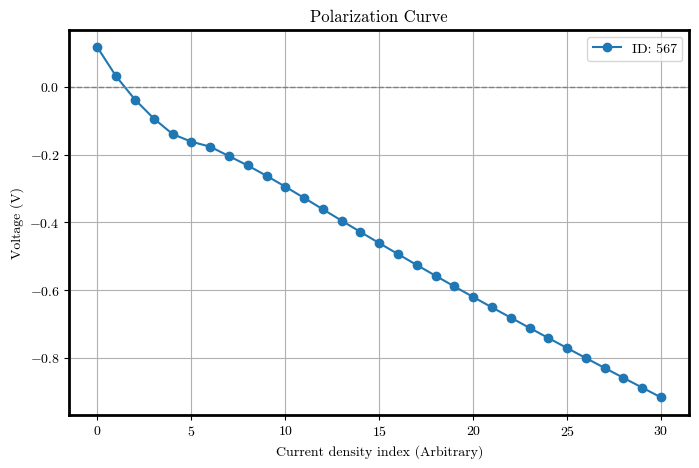

In [89]:
plot_polarization_curve(polarization_df.loc[567, :])

In [52]:
polarization_df[(polarization_df["start_in_range"] == True) &(polarization_df["early_values_in_range"] == False)][["id"] + check_cols].head()

,id,start_in_range,early_values_in_range,monotonic,minimum_voltage,classification
19,19,True,False,True,False,invalid
62,62,True,False,True,True,invalid
63,63,True,False,True,True,invalid
80,80,True,False,True,False,invalid
81,81,True,False,True,False,invalid


In [53]:
polarization_df[(polarization_df["monotonic"] == False) ][["id","start_in_range", "early_values_in_range", "monotonic"]].head()

,id,start_in_range,early_values_in_range,monotonic
21,21,False,False,False
22,22,False,False,False
52,52,False,False,False
54,54,False,False,False
55,55,False,False,False


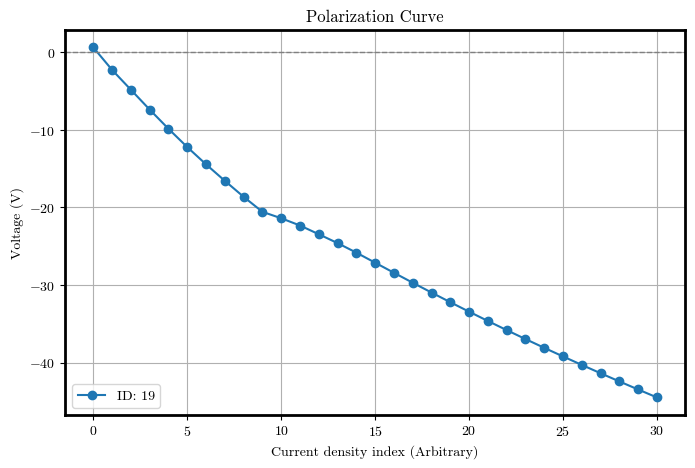

In [57]:
plot_polarization_curve(polarization_df.loc[19, :])

In [58]:
config_var_df[config_var_df["id"] == 21]

,id,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,Re,i0_c_ref,kappa_co,kappa_c,a_slim,b_slim,a_switch
21,21,343.0,110000.0,101325.0,1.733333,4.066667,0.7,0.4,0.55,2.0,0.4,0.25,4.0,5.100000e-07,166.667333,0.01,1.000000e-08,0.333333,0.333333,1.000000e-08


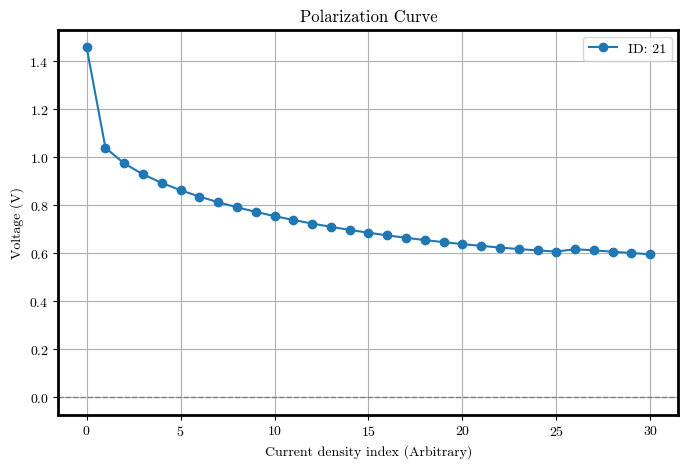

In [59]:
plot_polarization_curve(polarization_df.iloc[21, :])

#### Final configurations dataset + conditions for validity

In [93]:
config_var_df = pd.merge(config_var_df, polarization_df[["id"] + check_cols], on="id", how="left")
config_var_df.head()

,id,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,...,kappa_co,kappa_c,a_slim,b_slim,a_switch,start_in_range,early_values_in_range,monotonic,minimum_voltage,classification
0,0,343.0,110000.0,101325.0,1.733333,10.000000,0.7,0.4,0.550000,2.0,...,26.67,66.666667,1.000000e-08,1.000000e-08,1.000000e-08,False,False,True,True,invalid
1,1,363.0,110000.0,101325.0,1.733333,10.000000,0.7,0.4,0.550000,2.0,...,26.67,66.666667,1.000000e-08,1.000000e-08,1.000000e-08,False,False,True,True,invalid
2,2,363.0,110000.0,101325.0,1.733333,4.066667,0.7,0.4,0.550000,2.0,...,26.67,66.666667,1.000000e-08,1.000000e-08,1.000000e-08,False,False,True,True,invalid
3,3,363.0,110000.0,101325.0,1.733333,4.066667,0.7,0.4,0.550000,2.0,...,26.67,66.666667,1.000000e-08,1.000000e-08,1.000000e-08,False,False,True,True,invalid
4,4,363.0,110000.0,101325.0,1.733333,4.066667,0.7,0.4,0.716667,2.0,...,26.67,66.666667,1.000000e-08,1.000000e-08,1.000000e-08,False,False,True,True,invalid


Check that the pressure of the anode should be more than the pressure of the cathode -> we basically want to assert that Pa_des >= Pc_des

In [94]:
# Filter: Pa_des <= Pc_des
filtered_df = config_var_df[config_var_df["Pa_des"] <= config_var_df["Pc_des"]]

# Print value counts for 'classification'
filtered_df["classification"].value_counts()

classification
valid      317
invalid     22
Name: count, dtype: int64

In [95]:
# Filter: Pa_des <= Pc_des
filtered_df = config_var_df[config_var_df["Pa_des"] >= config_var_df["Pc_des"]]

# Print value counts for 'classification'
filtered_df["classification"].value_counts()

classification
invalid    609
valid      374
Name: count, dtype: int64

There doesn't seem to be a pattern. I conclude that Pa_des <= Pc_des did not necessarily cause the polarization curve to be wrong. 

In [97]:
config_var_df.head()

,id,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,...,kappa_co,kappa_c,a_slim,b_slim,a_switch,start_in_range,early_values_in_range,monotonic,minimum_voltage,classification
0,0,343.0,110000.0,101325.0,1.733333,10.000000,0.7,0.4,0.550000,2.0,...,26.67,66.666667,1.000000e-08,1.000000e-08,1.000000e-08,False,False,True,True,invalid
1,1,363.0,110000.0,101325.0,1.733333,10.000000,0.7,0.4,0.550000,2.0,...,26.67,66.666667,1.000000e-08,1.000000e-08,1.000000e-08,False,False,True,True,invalid
2,2,363.0,110000.0,101325.0,1.733333,4.066667,0.7,0.4,0.550000,2.0,...,26.67,66.666667,1.000000e-08,1.000000e-08,1.000000e-08,False,False,True,True,invalid
3,3,363.0,110000.0,101325.0,1.733333,4.066667,0.7,0.4,0.550000,2.0,...,26.67,66.666667,1.000000e-08,1.000000e-08,1.000000e-08,False,False,True,True,invalid
4,4,363.0,110000.0,101325.0,1.733333,4.066667,0.7,0.4,0.716667,2.0,...,26.67,66.666667,1.000000e-08,1.000000e-08,1.000000e-08,False,False,True,True,invalid


In [64]:
complete_df = pd.merge(config_var_df.drop(columns = check_cols), polarization_df, on = "id")
complete_df = complete_df.set_index("id")
complete_df.head()

,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,...,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,start_in_range,early_values_in_range,monotonic,minimum_voltage,classification
id,,,,,,,,,,,,,,,,,,,,,
0,343.0,110000.0,101325.0,1.733333,10.000000,0.7,0.4,0.550000,2.0,0.316667,...,0.892276,0.788229,0.682228,0.574121,0.463820,False,False,True,True,invalid
1,363.0,110000.0,101325.0,1.733333,10.000000,0.7,0.4,0.550000,2.0,0.316667,...,-0.598597,-0.738663,-0.882303,-1.029775,-1.181357,False,False,True,True,invalid
2,363.0,110000.0,101325.0,1.733333,4.066667,0.7,0.4,0.550000,2.0,0.316667,...,-1.323497,-1.486136,-1.653934,-1.827312,-2.006735,False,False,True,True,invalid
3,363.0,110000.0,101325.0,1.733333,4.066667,0.7,0.4,0.550000,2.0,0.316667,...,-1.323497,-1.486136,-1.653934,-1.827312,-2.006735,False,False,True,True,invalid
4,363.0,110000.0,101325.0,1.733333,4.066667,0.7,0.4,0.716667,2.0,0.316667,...,-0.132537,-0.217436,-0.303233,-0.389981,-0.477733,False,False,True,True,invalid


In [98]:
file_path = '../data/raw/complete_samples_up_until_270525.csv'
complete_df.to_csv(file_path, index=True)
print(f"Saved CSV to: {file_path}")

Saved CSV to: ../data/raw/complete_samples_up_until_270525.csv


In [99]:
df_for_classification = complete_df[ls_operating_conditions + ls_undetermined_physical_parameters + ["classification"]]
df_for_classification.to_csv('../data/raw/data_for_classification_up_until_270525.csv', index = True)